In [1]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# Utilities
from utils.viz_utils import *
from utils.custom_transformers import *
from utils.ml_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [243]:
chiu = pd.read_csv("chiu_cleaned.csv")

In [278]:
# for figure1
df = chiu.sort_values(by="dates", ascending=True)
df = df.reset_index(drop=True)
df["cum_avg_ratings"] = df["ratings"].expanding().mean().round(2)


df_groupby_dates = df.groupby("dates").agg(
    cum_avg_ratings=("cum_avg_ratings", "last"),
    avg_ratings=("ratings", lambda x: round(x.mean(), 2)),
    sum_of_counts=("dates", "count"),
)
## Coordinates for annotate
df_reset = df_groupby_dates.reset_index()
current_value = df_reset["cum_avg_ratings"].iloc[-1]
max_value = df_reset["cum_avg_ratings"].max()
min_value = df_reset["cum_avg_ratings"].min()
current_index = len(df_groupby_dates) - 1
max_index = df_reset["cum_avg_ratings"].idxmax()
min_index = df_reset["cum_avg_ratings"].idxmin()
max_x_value = df_reset.loc[max_index, "dates"]
max_y_value = df_reset.loc[max_index, "cum_avg_ratings"]
min_x_value = df_reset.loc[min_index, "dates"]
min_y_value = df_reset.loc[min_index, "cum_avg_ratings"]
current_x_value = df_reset.loc[current_index, "dates"]
current_y_value = df_reset.loc[current_index, "cum_avg_ratings"]

# for figure2
df_groupby_dates["rate_of_change"] = df_groupby_dates["avg_ratings"].pct_change() * 100
df_groupby_dates["rate_of_cum_change"] = (
    df_groupby_dates["cum_avg_ratings"].pct_change() * 100
)

# for figure3
# 提取年份
df["year"] = df["dates"].str[:4]

# 按年份分组并计数
yearly_counts = df.groupby("year").size()

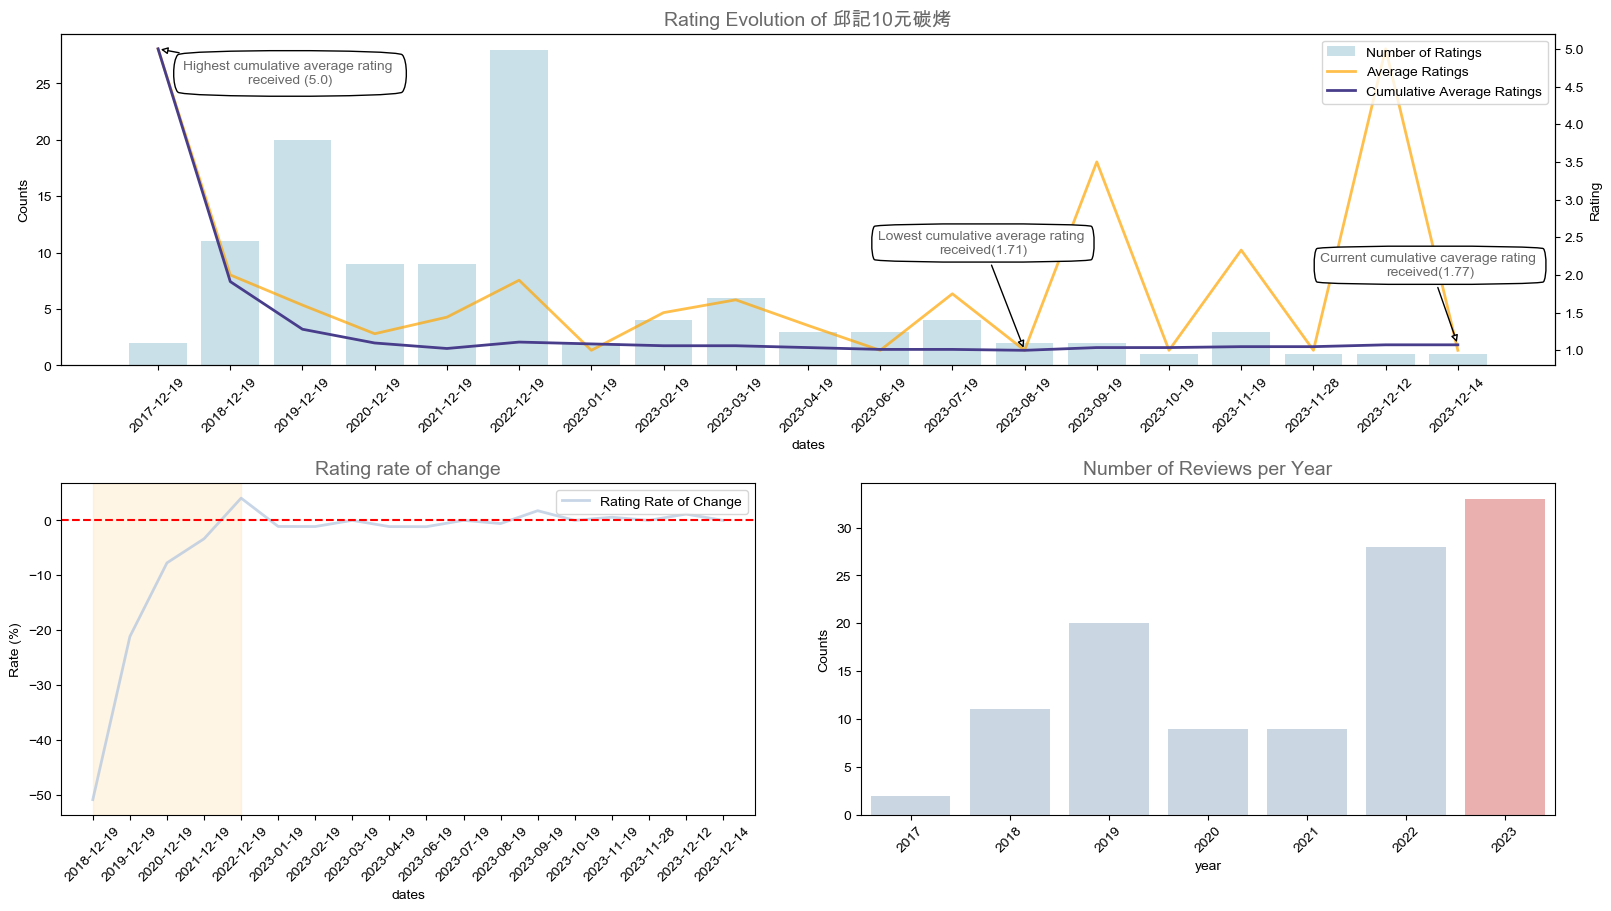

In [299]:
fig = plt.figure(constrained_layout=True, figsize=(16, 9))
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Set title
ax1.set_title("Rating Evolution of 邱記10元碳烤", size=14, color="dimgrey")


# Number of ratings
number_of_ratings_plot = sns.barplot(
    x=df_groupby_dates.index,
    y=df_groupby_dates["sum_of_counts"],
    ax=ax1,
    color="lightblue",
    linewidth=2,
    label="Number of Ratings",
    alpha=0.7,
    zorder=2,
)
ax1.set_zorder(3)
ax1.set_ylabel("Counts")  # 设置右侧 y 轴的标题

# Average ratings
ax1_1 = ax1.twinx()
avg_ratings_plot = sns.lineplot(
    x=df_groupby_dates.index,
    y=df_groupby_dates["avg_ratings"],
    ax=ax1_1,
    color="orange",
    linewidth=2,
    label="Average Ratings",
    alpha=0.7,
    zorder=2,
)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1_1.set_zorder(5)
ax1_1.set_ylabel("Rating")  # 设置右侧 y 轴的标题


# Cumulatively average ratings
ax1_2 = ax1.twinx()
cum_avg_ratings_plot = sns.lineplot(
    x=df_groupby_dates.index,
    y=df_groupby_dates["cum_avg_ratings"],
    ax=ax1_2,
    color="darkslateblue",
    linewidth=2,
    label="Cumulative Average Ratings",
)
ax1_2.annotate(
    f"Highest cumulative average rating \nreceived ({max_value})",
    (max_x_value, max_y_value),
    xytext=(95, -25),
    textcoords="offset points",
    bbox=dict(boxstyle="round4", fc="w", pad=0.8),
    arrowprops=dict(arrowstyle="-|>", fc="w"),
    color="dimgrey",
    ha="center",
)
ax1_2.annotate(
    f"Lowest cumulative average rating \nreceived({min_value})",
    (min_x_value, min_y_value),
    xytext=(-30, 70),
    textcoords="offset points",
    bbox=dict(boxstyle="round4", fc="w", pad=0.5),
    arrowprops=dict(arrowstyle="-|>", fc="w"),
    color="dimgrey",
    ha="center",
)
ax1_2.annotate(
    f"Current cumulative caverage rating \nreceived({current_value})",
    (current_x_value, current_y_value),
    xytext=(-20, 50),
    textcoords="offset points",
    bbox=dict(boxstyle="round4", fc="w", pad=0.5),
    arrowprops=dict(arrowstyle="-|>", fc="w"),
    color="dimgrey",
    ha="center",
)
ax1_2.axis("off")
ax1_2.set_zorder(5)

# Create a legend for the plots
# Since you have multiple axes, you need to manually gather the legend handles and labels
h0, l0 = number_of_ratings_plot.get_legend_handles_labels()
h1, l1 = avg_ratings_plot.get_legend_handles_labels()
h2, l2 = cum_avg_ratings_plot.get_legend_handles_labels()
cum_avg_ratings_plot.legend(
    h0 + h1 + h2, l0 + l1 + l2, title_fontsize="10", loc="upper right"
)
avg_ratings_plot.get_legend().remove()


ax2.set_title("Rating rate of change", size=14, color="dimgrey")
rate_of_cum_change_plot = sns.lineplot(
    x=df_groupby_dates.index,
    y=df_groupby_dates["rate_of_cum_change"],
    ax=ax2,
    color="lightsteelblue",
    linewidth=2,
    label="Rating Rate of Change",
    alpha=0.7,
    zorder=2,
)
ax2.set_zorder(3)
ax2.set_ylabel("Rate (%)")
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
ax2.axhline(0, color="red", linestyle="--", linewidth=1.5)
ax2.axvspan("2018-12-19", "2022-12-19", color="orange", alpha=0.1)


ax3.set_title("Number of Reviews per Year", size=14, color="dimgrey")
colors = ["lightsteelblue"] * len(df)  # 将所有柱的颜色初始化为蓝色
special_index = yearly_counts.index.get_loc("2023")  # 假设你要突出显示的是2023年
colors[special_index] = "lightcoral"

number_of_reviews_plot = sns.barplot(
    x=yearly_counts.index,
    y=yearly_counts,
    ax=ax3,
    palette=colors,
    linewidth=2,
    label="Rating Rate of Change",
    alpha=0.7,
    zorder=2,
)
ax3.set_zorder(3)
ax3.set_ylabel("Counts")
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)

plt.show()

       ratings  word_count
count   112.00      112.00
mean      1.77       32.96
std       1.41       35.79
min       1.00        0.00
25%       1.00        8.75
50%       1.00       26.00
75%       2.00       45.00
max       5.00      188.00
             ratings  word_count
ratings     1.000000   -0.058094
word_count -0.058094    1.000000
T-statistic: -0.5480482374367851, P-value: 0.5850622566822401
U-statistic: 275.0, P-value: 0.48599640625859863
T-statistic: 0.684096029281736, P-value: 0.4958201507919866
U-statistic: 182.0, P-value: 0.6853281315249649
T-statistic: -1.3159737520556156, P-value: 0.19172092828551576
U-statistic: 190.5, P-value: 0.3831482050709317
T-statistic: 1.2732181437939445, P-value: 0.2061484169370446
U-statistic: 720.0, P-value: 0.034130385316989295


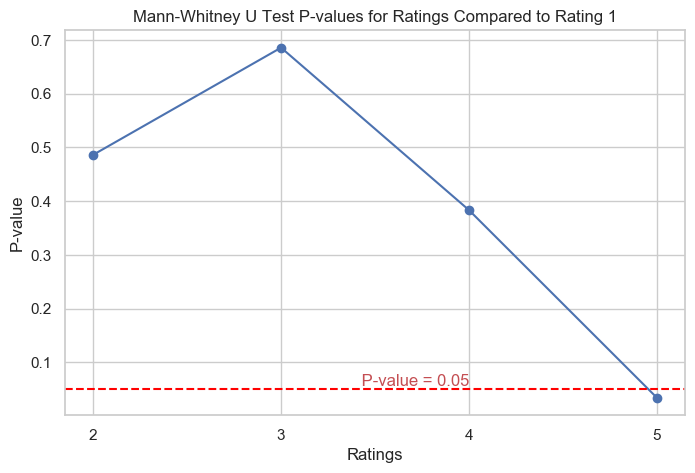

In [398]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

# for figure1,2
df["word_count"] = df["comments"].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
# 描述性统计分析
print(df[["ratings", "word_count"]].describe().round(2))
print(df[["ratings", "word_count"]].corr())

utest_p_value = []
# 筛选评分为 1 和 5 的数据
for i in list(range(2, 6)):
    df_rating_1 = df[df["ratings"] == 1]
    df_rating_n = df[df["ratings"] == i]

    # 进行 T 检验
    t_stat, p_val = ttest_ind(df_rating_1["word_count"], df_rating_n["word_count"])
    print(f"T-statistic: {t_stat}, P-value: {p_val}")

    # 进行 Mann-Whitney U 检验
    u_stat, p_val = mannwhitneyu(df_rating_1["word_count"], df_rating_n["word_count"])
    utest_p_value.append(p_val)
    print(f"U-statistic: {u_stat}, P-value: {p_val}")


# 对应的评分
ratings = list(range(2, 6))

# 绘制折线图
plt.figure(figsize=(8, 5))
plt.plot(ratings, utest_p_value, marker="o")
plt.axhline(0.05, color="red", linestyle="--", linewidth=1.5)
# 添加标题和轴标签
plt.title("Mann-Whitney U Test P-values for Ratings Compared to Rating 1")
plt.text(x=ratings[-2], y=0.05, s=" P-value = 0.05", color="r", va="bottom", ha="right")
plt.xlabel("Ratings")
plt.ylabel("P-value")
plt.xticks(ratings)  # 设置 x 轴刻度为评分值
plt.grid(True)

# 显示图表
plt.show()

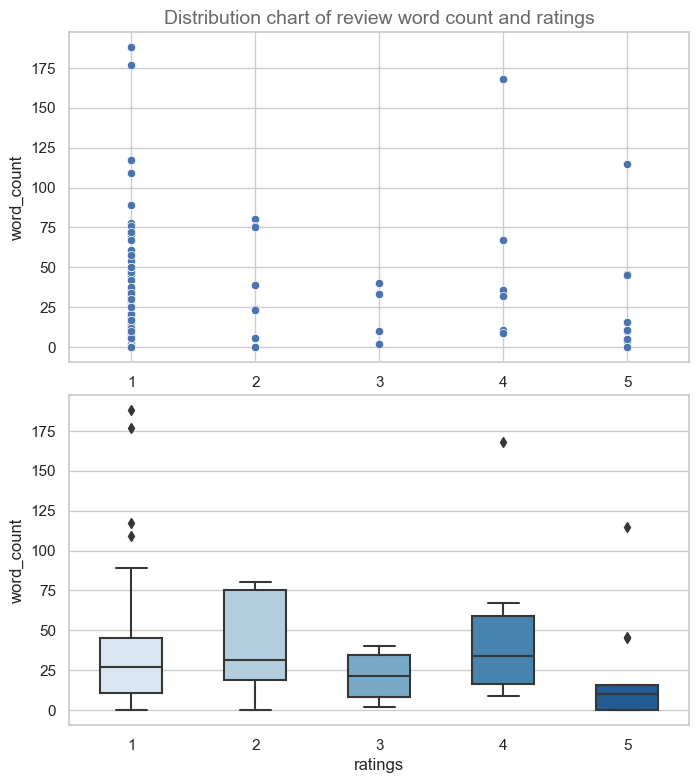

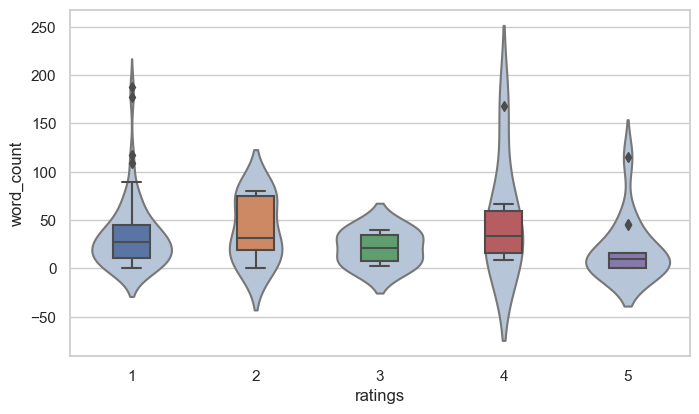

In [399]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 9))
sns.scatterplot(x=df["ratings"], y=df["word_count"], ax=ax1)
sns.boxplot(x=df["ratings"], y=df["word_count"], width=0.5, ax=ax2, palette="Blues")
ax1.set_title(
    "Distribution chart of review word count and ratings", size=14, color="dimgrey"
)
xticks = ax1.get_xticks()
ax1.set_xticks([tick for tick in xticks if tick != 0])
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # 使箱形图只显示整数刻度
ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # 也可以使散点图只显示整数刻度
plt.subplots_adjust(hspace=0.1)
plt.show()


# violinwithboxplot
plt.figure(figsize=(8, 4.5))
sns.boxplot(x="ratings", y="word_count", data=df, width=0.3, boxprops={"zorder": 2})
sns.violinplot(
    x="ratings",
    y="word_count",
    color="lightsteelblue",
    data=df,
    inner=None,
    width=0.7,
    alpha=0.7,
)
plt.show()

In [453]:
df_rating_1 = df[df["ratings"] == 1]
df_rating_2 = df[df["ratings"] == 2]
df_rating_3 = df[df["ratings"] == 3]
df_rating_4 = df[df["ratings"] == 4]
df_rating_5 = df[df["ratings"] == 5]

In [457]:
import math
from snownlp import SnowNLP
from opencc import OpenCC

In [466]:
df_rating_1_sentiment = []
df_rating_2_sentiment = []
df_rating_3_sentiment = []
df_rating_4_sentiment = []
df_rating_5_sentiment = []
t2c = OpenCC("t2s")

comments = list(df_rating_1["comments"])
comments = [x for x in comments if not pd.isna(x)]
for comment in comments:
    comment = t2c.convert(comment)
    s = SnowNLP(comment)
    sentiment = s.sentiments  # 输出一个介于0（负面）到1（正面）之间的情感分数
    df_rating_1_sentiment.append(sentiment)
    print(f"評論：{comment} \n情感分數：{sentiment}\n")

comments = list(df_rating_2["comments"])
comments = [x for x in comments if not pd.isna(x)]
for comment in comments:
    comment = t2c.convert(comment)
    s = SnowNLP(comment)
    sentiment = s.sentiments  # 输出一个介于0（负面）到1（正面）之间的情感分数
    df_rating_2_sentiment.append(sentiment)
    print(f"評論：{comment} \n情感分數：{sentiment}\n")

comments = list(df_rating_3["comments"])
comments = [x for x in comments if not pd.isna(x)]
for comment in comments:
    comment = t2c.convert(comment)
    s = SnowNLP(comment)
    sentiment = s.sentiments  # 输出一个介于0（负面）到1（正面）之间的情感分数
    df_rating_3_sentiment.append(sentiment)
    print(f"評論：{comment} \n情感分數：{sentiment}\n")

comments = list(df_rating_4["comments"])
comments = [x for x in comments if not pd.isna(x)]
for comment in comments:
    comment = t2c.convert(comment)
    s = SnowNLP(comment)
    sentiment = s.sentiments  # 输出一个介于0（负面）到1（正面）之间的情感分数
    df_rating_4_sentiment.append(sentiment)
    print(f"評論：{comment} \n情感分數：{sentiment}\n")

comments = list(df_rating_5["comments"])
comments = [x for x in comments if not pd.isna(x)]
for comment in comments:
    comment = t2c.convert(comment)
    s = SnowNLP(comment)
    sentiment = s.sentiments  # 输出一个介于0（负面）到1（正面）之间的情感分数
    df_rating_5_sentiment.append(sentiment)
    print(f"評論：{comment} \n情感分數：{sentiment}\n")

評論：10元的品项很少。肉很柴，这价位我是不会再去第二次了 
情感分數：0.5102326045246436

評論：热狗很粉、甜不辣又干又硬
鸡翅干到几乎没有油脂了@@绝对不会二访的店 
情感分數：0.08778518711578831

評論：甜不辣不新鲜、香菇没熟、其他的烤物都是冷的。
花了三百多，有三分之二不能吃。实在是雷店👎
很难想像在公馆会有这样的店！ … 
情感分數：0.0042552314790834656

評論：态度亲切但不好吃
甜不辣咬下去是硬硬干干的 
情感分數：0.1788086289160148

評論：百页豆腐跟甜不辣吃起来有酸臭味食材不新鲜 
情感分數：0.23383759924128178

評論：老板态度随便，最重要的是超难吃。一串40元的鸡肉串竟然会没烤熟，愈吃愈恶心，吃到剩一半干脆丢掉。这种水准竟然还可以在公馆夜市摆摊，真是太可怕了。 
情感分數：0.00014889229734793563

評論：米肠没熟，里面的还吃得到生的米，重点是钱还乱算，买了$110被收140，给了一千当下还好意思问我有没有小张一点的。当下没多想以为自己买了什么没记清楚（本来已经想好有刚好的$110可以给），结果明明就是被多算==真的够烂 
情感分數：0.00012446080434158624

評論：不优，老板也不优 
情感分數：0.9375420402260577

評論：可以说明一下，为什么烤烧烤没有烤肉酱？
感觉难吃，就鲁过烤烤再加一点胡椒...
你们板桥湳雅分店今天吃了看来跟你一样
我心中的理想美味不见了 
情感分數：0.9729307749499829

評論：猪肉串,鸡肉串还好, 但甜不辣感觉像粉做的，又硬又干, 咬一口就吞不下去了, 15元飞了..... 
情感分數：0.01060902354962423

評論：甜不辣 米血都没熟.....不知道自己在吃什么,还好没点肉类。
老板边抽烟边弄食材,真的很不行。 
情感分數：0.014739021494606042

評論：每次钱都乱算 当你点很多都乱算钱 去两次 两次都被坑 按照菜单算的都不会是你算出来的 有够不诚实
完全不推荐 
情感分數：7.696231076947946e-05

評論：大家要注意，钱要算对啊，老板被说算错也没有一丝歉意的样子。 
情感分數：0.35013754

In [470]:
setiment1 = np.mean(df_rating_1_sentiment)
setiment2 = np.mean(df_rating_2_sentiment)
setiment3 = np.mean(df_rating_3_sentiment)
setiment4 = np.mean(df_rating_4_sentiment)
setiment5 = np.mean(df_rating_5_sentiment)

SyntaxError: invalid syntax (2040443312.py, line 5)

In [465]:
for comment in comments:
    comment = t2c.convert(comment)
    s = SnowNLP(comment)
    sentiment = s.sentiments  # 输出一个介于0（负面）到1（正面）之间的情感分数
    df_rating_1_sentiment.append(sentiment)
    print(f"評論：{comment} \n情感分數：{sentiment}\n")

評論：10元的品项很少。肉很柴，这价位我是不会再去第二次了 
情感分數：0.5102326045246436

評論：热狗很粉、甜不辣又干又硬
鸡翅干到几乎没有油脂了@@绝对不会二访的店 
情感分數：0.08778518711578831

評論：甜不辣不新鲜、香菇没熟、其他的烤物都是冷的。
花了三百多，有三分之二不能吃。实在是雷店👎
很难想像在公馆会有这样的店！ … 
情感分數：0.0042552314790834656

評論：态度亲切但不好吃
甜不辣咬下去是硬硬干干的 
情感分數：0.1788086289160148

評論：百页豆腐跟甜不辣吃起来有酸臭味食材不新鲜 
情感分數：0.23383759924128178

評論：老板态度随便，最重要的是超难吃。一串40元的鸡肉串竟然会没烤熟，愈吃愈恶心，吃到剩一半干脆丢掉。这种水准竟然还可以在公馆夜市摆摊，真是太可怕了。 
情感分數：0.00014889229734793563

評論：米肠没熟，里面的还吃得到生的米，重点是钱还乱算，买了$110被收140，给了一千当下还好意思问我有没有小张一点的。当下没多想以为自己买了什么没记清楚（本来已经想好有刚好的$110可以给），结果明明就是被多算==真的够烂 
情感分數：0.00012446080434158624

評論：不优，老板也不优 
情感分數：0.9375420402260577

評論：可以说明一下，为什么烤烧烤没有烤肉酱？
感觉难吃，就鲁过烤烤再加一点胡椒...
你们板桥湳雅分店今天吃了看来跟你一样
我心中的理想美味不见了 
情感分數：0.9729307749499829

評論：猪肉串,鸡肉串还好, 但甜不辣感觉像粉做的，又硬又干, 咬一口就吞不下去了, 15元飞了..... 
情感分數：0.01060902354962423

評論：甜不辣 米血都没熟.....不知道自己在吃什么,还好没点肉类。
老板边抽烟边弄食材,真的很不行。 
情感分數：0.014739021494606042

評論：每次钱都乱算 当你点很多都乱算钱 去两次 两次都被坑 按照菜单算的都不会是你算出来的 有够不诚实
完全不推荐 
情感分數：7.696231076947946e-05

評論：大家要注意，钱要算对啊，老板被说算错也没有一丝歉意的样子。 
情感分數：0.35013754

In [425]:
from snownlp import SnowNLP
from opencc import OpenCC

# 创建转换器，从繁体转换到简体
tc = OpenCC("t2s")  # t2s 表示 Traditional Chinese to Simplified Chinese

comments = ["這是一個很棒的產品！", "真的很糟糕，我不喜歡。", "還行，可改進。", "垃圾爛透了", "去給你媽摺蓮花。"]

for comment in comments:
    s = SnowNLP(comment)
    sentiment = s.sentiments  # 输出一个介于0（负面）到1（正面）之间的情感分数
    print(f"評論：{comment} \n情感分數：{sentiment}\n")

    comment = tc.convert(comment)
    s = SnowNLP(comment)
    sentiment = s.sentiments  # 输出一个介于0（负面）到1（正面）之间的情感分数
    print(f"評論：{comment} \n情感分數：{sentiment}\n")

評論：這是一個很棒的產品！ 
情感分數：0.8504302211064388

評論：这是一个很棒的产品！ 
情感分數：0.858701323608539

評論：真的很糟糕，我不喜歡。 
情感分數：0.5095142011919661

評論：真的很糟糕，我不喜欢。 
情感分數：0.5918518834399712

評論：還行，可改進。 
情感分數：0.14825344966157183

評論：还行，可改进。 
情感分數：0.7656440352158514

評論：垃圾爛透了 
情感分數：0.1650209291839938

評論：垃圾烂透了 
情感分數：0.025103848136498907

評論：去給你媽摺蓮花。 
情感分數：0.17633664112818026

評論：去给你妈折莲花。 
情感分數：0.6939150675662011



[('这个', 0.5262327818078083), ('产品', 0.5347593582887697), ('真', 0.5305096913137115), ('不错', 0.8612132352941176), ('，', 0.5262327818078083), ('我', 0.5262327818078083), ('很', 0.6732684101105153), ('喜欢', 0.6994590939824207), ('。', 0.5262327818078083), ('但是', 0.5262327818078083), ('运送', 0.5), ('过程', 0.6678700361010828), ('中', 0.7150301700493692), ('有点', 0.5262327818078083), ('问题', 0.5262327818078083), ('。', 0.5262327818078083)]
['不錯', '很', '喜歡', '過程', '中'] ['這個', '產品', '真', '，', '我', '。', '但是', '運送', '有點', '問題', '。']
正面情感词比例: 0.3125
负面情感词比例: 0.6875


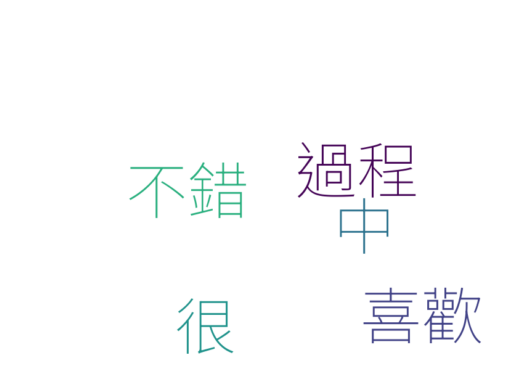

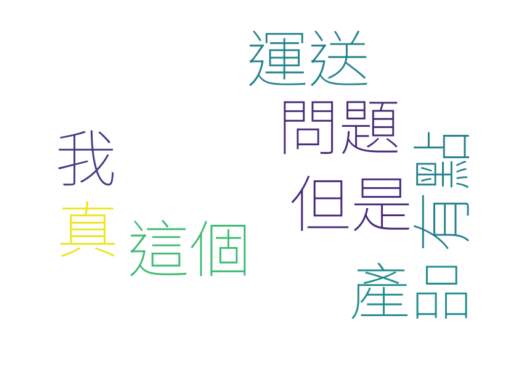

In [452]:
from snownlp import SnowNLP
from wordcloud import WordCloud
import matplotlib.pyplot as plt

c2t = OpenCC("s2t")

text = "这个产品真不错，我很喜欢。但是运送过程中有点问题。"
s = SnowNLP(text)
words_sentiments = [(word, SnowNLP(word).sentiments) for word in s.words]
print(words_sentiments)
# 提取正面和负面情感词
positive_words = [word for word, sentiment in words_sentiments if sentiment > 0.66]
negative_words = [word for word, sentiment in words_sentiments if sentiment <= 0.55]
positive_words = [c2t.convert(word) for word in positive_words]
negative_words = [c2t.convert(word) for word in negative_words]

print(positive_words, negative_words)
# 计算比例
total_words = len(s.words)
positive_ratio = len(positive_words) / total_words
negative_ratio = len(negative_words) / total_words

print("正面情感词比例:", positive_ratio)
print("负面情感词比例:", negative_ratio)


def generate_wordcloud(words):
    wordcloud = WordCloud(
        font_path="NotoSansTC-VariableFont_wght.ttf",
        background_color="white",
        width=800,  # 增加宽度
        height=600,  # 增加高度
        max_words=100,  # 可以显示的最大词数
        max_font_size=100,  # 最大字体大小
        min_font_size=10,  # 最小字体大小
    ).generate(" ".join(words))

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


generate_wordcloud(positive_words)
generate_wordcloud(negative_words)

In [ ]:
# for figure1
df = chiu.sort_values(by="dates", ascending=True)
df = df.reset_index(drop=True)
df["cum_avg_ratings"] = df["ratings"].expanding().mean().round(2)


df_groupby_dates = df.groupby("dates").agg(
    cum_avg_ratings=("cum_avg_ratings", "last"),
    avg_ratings=("ratings", lambda x: round(x.mean(), 2)),
    sum_of_counts=("dates", "count"),
)
## Coordinates for annotate
df_reset = df_groupby_dates.reset_index()
current_value = df_reset["cum_avg_ratings"].iloc[-1]
max_value = df_reset["cum_avg_ratings"].max()
min_value = df_reset["cum_avg_ratings"].min()
current_index = len(df_groupby_dates) - 1
max_index = df_reset["cum_avg_ratings"].idxmax()
min_index = df_reset["cum_avg_ratings"].idxmin()
max_x_value = df_reset.loc[max_index, "dates"]
max_y_value = df_reset.loc[max_index, "cum_avg_ratings"]
min_x_value = df_reset.loc[min_index, "dates"]
min_y_value = df_reset.loc[min_index, "cum_avg_ratings"]
current_x_value = df_reset.loc[current_index, "dates"]
current_y_value = df_reset.loc[current_index, "cum_avg_ratings"]

# for figure2
df_groupby_dates["rate_of_change"] = df_groupby_dates["avg_ratings"].pct_change() * 100
df_groupby_dates["rate_of_cum_change"] = (
    df_groupby_dates["cum_avg_ratings"].pct_change() * 100
)

# for figure3
# 提取年份
df["year"] = df["dates"].str[:4]

# 按年份分组并计数
yearly_counts = df.groupby("year").size()

In [ ]:
# Filtering data between 201701 and 201808
df_orders_filt = df_orders_items[
    (df_orders_items["order_purchase_year_month"].astype(int) >= 201701)
]
df_orders_filt = df_orders_filt[
    (df_orders_filt["order_purchase_year_month"].astype(int) <= 201808)
]

# Grouping data by region
df_regions_group = df_orders_filt.groupby(
    by=["order_purchase_year_month", "nome_regiao"], as_index=False
)
df_regions_group = df_regions_group.agg(
    {"customer_id": "count", "price": "sum"}
).sort_values(by="order_purchase_year_month")
df_regions_group.columns = ["month", "region", "order_count", "order_amount"]
df_regions_group.reset_index(drop=True, inplace=True)

# Grouping data by city (top 10)
df_cities_group = (
    df_orders_filt.groupby(by="geolocation_city", as_index=False)
    .count()
    .loc[:, ["geolocation_city", "order_id"]]
)
df_cities_group = df_cities_group.sort_values(
    by="order_id", ascending=False
).reset_index(drop=True)
df_cities_group = df_cities_group.iloc[:10, :]

In [ ]:
# Creating and preparing figure and axis
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

# Count of orders by region
sns.lineplot(
    x="month",
    y="order_count",
    ax=ax1,
    data=df_regions_group,
    hue="region",
    size="region",
    style="region",
    palette="magma",
    markers=["o"] * 5,
)
format_spines(ax1, right_border=False)
ax1.set_title(
    "Evolution of E-Commerce Orders on Brazilian Regions", size=12, color="dimgrey"
)
ax1.set_ylabel("")
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Top cities with more customers orders in Brazil
sns.barplot(
    y="geolocation_city", x="order_id", data=df_cities_group, ax=ax2, palette="magma"
)
AnnotateBars(n_dec=0, font_size=10, color="black").horizontal(ax2)
format_spines(ax2, right_border=False)
ax2.set_title("Top 10 Brazilian Cities with More Orders", size=12, color="dimgrey")
ax2.set_ylabel("")

# Total orders by state
single_countplot(y="customer_state", ax=ax3, df=df_orders_filt, palette="viridis")
ax3.set_title("Total of Customers Orders by State", size=12, color="dimgrey")
ax3.set_ylabel("")

plt.show()

---
- _How about the e-commerce sales? Did they grow up over time?_
---


In [ ]:
# Grouping data
df_month_aggreg = df_orders_filt.groupby(
    by=["order_purchase_year", "order_purchase_year_month"], as_index=False
)
df_month_aggreg = df_month_aggreg.agg(
    {"order_id": "count", "price": "sum", "freight_value": "sum"}
)

# Adding new columns for analysis
df_month_aggreg["price_per_order"] = (
    df_month_aggreg["price"] / df_month_aggreg["order_id"]
)
df_month_aggreg["freight_per_order"] = (
    df_month_aggreg["freight_value"] / df_month_aggreg["order_id"]
)
df_month_aggreg.head()

In [ ]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1:])

# Plot 1 - Evolution of total orders and total sales on e-commerce
sns.lineplot(
    x="order_purchase_year_month",
    y="price",
    ax=ax1,
    data=df_month_aggreg,
    linewidth=2,
    color="darkslateblue",
    marker="o",
    label="Total Amount",
)
ax1_twx = ax1.twinx()
single_countplot(
    df_orders_filt,
    x="order_purchase_year_month",
    ax=ax1_twx,
    order=False,
    palette="YlGnBu_r",
)
ax1_twx.set_yticks(np.arange(0, 20000, 2500))

# Customizing the first plot
format_spines(ax1)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.price.items():
    ax1.annotate(
        str(round(y / 1000, 1)) + "K",
        xy=(x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        color="dimgrey",
    )
ax1.annotate(
    f"Highest Value Sold on History\n(Black Friday?)",
    (10, 1000000),
    xytext=(-120, -20),
    textcoords="offset points",
    bbox=dict(boxstyle="round4", fc="w", pad=0.8),
    arrowprops=dict(arrowstyle="-|>", fc="w"),
    color="dimgrey",
    ha="center",
)
ax1.set_title(
    "Evolution of E-commerce: Total Orders and Total Amount Sold (R$)",
    size=14,
    color="dimgrey",
    pad=20,
)

# Plot 2 - Big Numbers of Sales Evolution
month_comparison = [
    "201701",
    "201702",
    "201703",
    "201704",
    "201705",
    "201706",
    "201707",
    "201708",
    "201801",
    "201802",
    "201803",
    "201804",
    "201805",
    "201806",
    "201807",
    "201808",
]
df_sales_compare = df_month_aggreg.query(
    "order_purchase_year_month in (@month_comparison)"
)
sold_2017 = df_sales_compare.query("order_purchase_year == 2017")["price"].sum()
sold_2018 = df_sales_compare.query("order_purchase_year == 2018")["price"].sum()
growth = 1 + (sold_2017 / sold_2018)
ax2.text(
    0.50,
    0.73,
    "R$" + str(round(sold_2017 / 1000000, 2)) + "M",
    fontsize=40,
    color="mediumseagreen",
    ha="center",
)
ax2.text(
    0.50,
    0.60,
    "total amount sold in 2017\nbetween January and August",
    fontsize=10,
    ha="center",
)
ax2.text(
    0.50,
    0.36,
    "R$" + str(round(sold_2018 / 1000000, 2)) + "M",
    fontsize=60,
    color="darkslateblue",
    ha="center",
)
ax2.text(
    0.50,
    0.25,
    "total amount sold in 2018\nbetween January and August",
    fontsize=10,
    ha="center",
)
signal = "+" if growth > 0 else "-"
ax2.text(
    0.50,
    0.13,
    f"{signal}{str(round(100 * growth, 2))}%",
    fontsize=14,
    ha="center",
    color="white",
    style="italic",
    weight="bold",
    bbox=dict(facecolor="navy", alpha=0.5, pad=10, boxstyle="round, pad=.7"),
)
ax2.axis("off")

# Plot 3 - Evolution of mean freight value paid by the customers
sns.lineplot(
    x="order_purchase_year_month",
    y="freight_per_order",
    data=df_month_aggreg,
    linewidth=2,
    color="silver",
    marker="o",
    ax=ax3,
)
format_spines(ax3, right_border=False)
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.freight_per_order.items():
    ax3.annotate(
        round(y, 2),
        xy=(x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        color="dimgrey",
    )
ax3.set_title(
    "Evolution of Average Freight Value (RS) Paid by Customers",
    size=14,
    color="dimgrey",
    pad=20,
)

plt.tight_layout()
plt.show()

# Comments Analysis


In [ ]:
# Calculating working days between purchasing, delivering and estimated delivery
purchasing = df_orders_filt["order_purchase_timestamp"]
delivered = df_orders_filt["order_delivered_customer_date"]
estimated = df_orders_filt["order_estimated_delivery_date"]
df_orders_filt["time_to_delivery"] = calc_working_days(
    purchasing, delivered, convert=True
)
df_orders_filt["diff_estimated_delivery"] = calc_working_days(
    estimated, delivered, convert=True
)

# Grouping data by state
states_avg_grouped = df_orders_filt.groupby(by="customer_state", as_index=False)[
    "freight_value"
].mean()
states_freight_paid = states_avg_grouped.loc[:, ["customer_state", "freight_value"]]
states_avg_grouped = df_orders_filt.groupby(by="customer_state", as_index=False)[
    "time_to_delivery"
].mean()
states_time_to_delivery = states_avg_grouped.loc[
    :, ["customer_state", "time_to_delivery"]
]
states_avg_grouped = df_orders_filt.groupby(by="customer_state", as_index=False)[
    "diff_estimated_delivery"
].mean()
states_estimated_delivery = states_avg_grouped.loc[
    :, ["customer_state", "diff_estimated_delivery"]
]

# Sorting data
states_freight_paid = states_freight_paid.sort_values(
    by="freight_value", ascending=False
)
states_time_to_delivery = states_time_to_delivery.sort_values(
    by="time_to_delivery", ascending=False
)
states_estimated_delivery = states_estimated_delivery.sort_values(
    by="diff_estimated_delivery"
)

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Plot Pack 01 - Freight value paid on states
sns.barplot(
    x="freight_value",
    y="customer_state",
    data=states_freight_paid.head(),
    ax=axs[1, 0],
    palette="viridis",
)
axs[1, 0].set_title(
    "Top 5 States with Highest \nAverage Freight Value", size=12, color="black"
)
sns.barplot(
    x="freight_value",
    y="customer_state",
    data=states_freight_paid.tail(),
    ax=axs[2, 0],
    palette="viridis_r",
)
axs[2, 0].set_title(
    "Top 5 States with Lowest \nAverage Freight Value", size=12, color="black"
)
for ax in axs[1, 0], axs[2, 0]:
    ax.set_xlabel("Mean Freight Value")
    ax.set_xlim(0, states_freight_paid["freight_value"].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel("")

# Annotations
axs[0, 0].text(
    0.50,
    0.30,
    f"R${round(df_orders_filt.freight_value.mean(), 2)}",
    fontsize=45,
    ha="center",
)
axs[0, 0].text(
    0.50, 0.12, "is the mean value of freight paid", fontsize=12, ha="center"
)
axs[0, 0].text(0.50, 0.00, "for online shopping", fontsize=12, ha="center")
axs[0, 0].axis("off")

# Plot Pack 02 - Time to delivery on states
sns.barplot(
    x="time_to_delivery",
    y="customer_state",
    data=states_time_to_delivery.head(),
    ax=axs[1, 1],
    palette="viridis",
)
axs[1, 1].set_title(
    "Top 5 States with Highest \nAverage Time to Delivery", size=12, color="black"
)
sns.barplot(
    x="time_to_delivery",
    y="customer_state",
    data=states_time_to_delivery.tail(),
    ax=axs[2, 1],
    palette="viridis_r",
)
axs[2, 1].set_title(
    "Top 5 States with Lowest \nAverage Time do Delivery", size=12, color="black"
)
for ax in axs[1, 1], axs[2, 1]:
    ax.set_xlabel("Time to Delivery")
    ax.set_xlim(0, states_time_to_delivery["time_to_delivery"].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel("")

# Annotations
axs[0, 1].text(
    0.40,
    0.30,
    f"{int(df_orders_filt.time_to_delivery.mean())}",
    fontsize=45,
    ha="center",
)
axs[0, 1].text(0.60, 0.30, "working days", fontsize=12, ha="center")
axs[0, 1].text(
    0.50, 0.12, "is the average delay for delivery", fontsize=12, ha="center"
)
axs[0, 1].text(0.50, 0.00, "for online shopping", fontsize=12, ha="center")
axs[0, 1].axis("off")

# Plot Pack 03 - Differnece between delivered and estimated on states
sns.barplot(
    x="diff_estimated_delivery",
    y="customer_state",
    data=states_estimated_delivery.head(),
    ax=axs[1, 2],
    palette="viridis",
)
axs[1, 2].set_title(
    "Top 5 States where Delivery is \nReally Fast Comparing to Estimated",
    size=12,
    color="black",
)
sns.barplot(
    x="diff_estimated_delivery",
    y="customer_state",
    data=states_estimated_delivery.tail(),
    ax=axs[2, 2],
    palette="viridis_r",
)
axs[2, 2].set_title(
    "Top 5 States where Delivery is \nNot So Fast Comparing to Estimated",
    size=12,
    color="black",
)
for ax in axs[1, 2], axs[2, 2]:
    ax.set_xlabel("Days Between Delivery and Estimated")
    ax.set_xlim(
        states_estimated_delivery["diff_estimated_delivery"].min() - 1,
        states_estimated_delivery["diff_estimated_delivery"].max() + 1,
    )
    format_spines(ax, right_border=False)
    ax.set_ylabel("")

# Annotations
axs[0, 2].text(
    0.40,
    0.30,
    f"{int(df_orders_filt.diff_estimated_delivery.mean())}",
    fontsize=45,
    ha="center",
)
axs[0, 2].text(0.60, 0.30, "working days", fontsize=12, ha="center")
axs[0, 2].text(
    0.50, 0.12, "is the average difference between", fontsize=12, ha="center"
)
axs[0, 2].text(0.50, 0.00, "delivery and estimated date", fontsize=12, ha="center")
axs[0, 2].axis("off")

plt.suptitle("Comparative Study: E-Commerce on Brazilian States", size=16)
plt.tight_layout()
plt.show()

# Big Issue


In [ ]:
# Grouping data
df_orders_pay = df_orders_filt.merge(olist_order_payments, how="left", on="order_id")

# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# Plot 1 - Payment types in a donut chart
colors = ["darkslateblue", "cornflowerblue", "silver", "darkviolet", "crimson"]
label_names = df_orders_pay["payment_type"].value_counts().index
donut_plot(
    df_orders_pay,
    col="payment_type",
    ax=ax1,
    label_names=label_names,
    colors=colors,
    title="Count of Transactions by Payment Type",
    text=f"{len(df_orders_pay)}\npayments \nregistered",
)

# Plot 2 - Payment installments
single_countplot(df_orders_pay, ax=ax2, y="payment_installments")
ax2.set_title("A Distribution of Payment Installments", color="dimgrey", size=12)

# Plot 3 - Evolution of payment types
payment_evl = df_orders_pay.groupby(
    by=["order_purchase_year_month", "payment_type"], as_index=False
).count()
payment_evl = payment_evl.loc[
    :, ["order_purchase_year_month", "payment_type", "order_id"]
]
payment_evl = payment_evl.sort_values(
    by=["order_purchase_year_month", "order_id"], ascending=[True, False]
)
sns.lineplot(
    x="order_purchase_year_month",
    y="order_id",
    data=payment_evl,
    ax=ax3,
    hue="payment_type",
    style="payment_type",
    size="payment_type",
    palette=colors,
    marker="o",
)
format_spines(ax3, right_border=False)
ax3.set_title(
    "Evolution of Payment Types in Brazilian E-Commerce", size=12, color="dimgrey"
)
plt.show()

# Word Cloud + Positive, Negative ratio


In [ ]:
# Reading and preparing a mask for serving as wordcloud background
like_mask = np.array(Image.open("../data/like.png"))
bomb_mask = np.array(Image.open("../data/bomb.png"))
# angry_mask = angry_mask[:, :, -1]

# Transforming like mask
transf_like_mask = np.ndarray((like_mask.shape[0], like_mask.shape[1]), np.int32)
for i in range(len(like_mask)):
    transf_like_mask[i] = [255 if px == 0 else 0 for px in like_mask[i]]

# Transforming angry mask
transf_bomb_mask = np.ndarray((bomb_mask.shape[0], bomb_mask.shape[1]), np.int32)
for i in range(len(bomb_mask)):
    transf_bomb_mask[i] = [255 if px == 0 else 0 for px in like_mask[i]]

##for i in range(len(bomb_mask)):
##    transf_bomb_mask[i] = [255 if px == 0 else 0 for px in bomb_mask[i]]

# Generating words
pos_comments = list(
    df_comments.query('sentiment_label == "positive"')["stopwords_removed"].values
)
positive_words = " ".join(pos_comments).split(" ")
neg_comments = list(
    df_comments.query('sentiment_label == "negative"')["stopwords_removed"].values
)
negative_words = " ".join(neg_comments).split(" ")

# Using Counter for creating a dictionary counting
positive_dict = Counter(positive_words)
negative_dict = Counter(negative_words)

# Generating wordclouds for both positive and negative comments
positive_wc = WordCloud(
    width=1280,
    height=720,
    collocations=False,
    random_state=42,
    mask=transf_like_mask,
    colormap="Blues",
    background_color="white",
    max_words=50,
).generate_from_frequencies(positive_dict)
negative_wc = WordCloud(
    width=1280,
    height=720,
    collocations=False,
    random_state=42,
    mask=transf_bomb_mask,
    colormap="Reds",
    background_color="white",
    max_words=50,
).generate_from_frequencies(negative_dict)

# Visualizing the WC created and the total for each cuisine
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
ax1 = axs[0]
ax2 = axs[1]

ax1.imshow(positive_wc)
ax1.axis("off")
ax1.set_title("WordCloud for Positive Words in Reviews", size=18, pad=20)

ax2.imshow(negative_wc)
ax2.axis("off")
ax2.set_title("WordCloud for Negative Words in Reviews", size=18, pad=20)

plt.show()